[구글 코랩(Colab)에서 실행하기](https://colab.research.google.com/github/lovedlim/tensorflow/blob/main/Part%204/4.6_segmentation.ipynb)

## Import

In [1]:
!pip install tensorflow-datasets

In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pylab as plt
import cv2
from tqdm.notebook import tqdm
import tensorflow_datasets as tfds
#from google.colab.patches import cv2_imshow

## 주요 파라미터 설정

In [3]:
# 이미지 크기
img_w = 128
img_h = 128
img_c = 3
img_shape = (img_w,img_h,img_c)

# 모델 학습
epoch_num = 5
learning_rate = 0.0001
buffer_size = 1000
batch_size = 16

## 데이터셋

In [4]:
# 텐서플로 데이터셋 로드 
ds_str='oxford_iiit_pet'
ds, info = tfds.load(name=ds_str, with_info=True)

In [5]:
# 이미지 전처리 함수 
def preprocess_image(ds):
    # 원본 이미지
    img = tf.image.resize(ds['image'], (img_w, img_h))
    img = tf.cast(img, tf.float32) / 255.0
    # 분할 마스크 
    mask = tf.image.resize(ds['segmentation_mask'], (img_w, img_h))
    mask = tf.cast(mask, tf.int32)
    mask = mask - 1
    return img, mask

In [6]:
# 데이터 전처리 파이프라인
train_ds = ds['train'].map(preprocess_image).shuffle(buffer_size).batch(batch_size).prefetch(2)
test_ds = ds['test'].map(preprocess_image).shuffle(buffer_size).batch(batch_size).prefetch(2)

print(train_ds)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 128, 128, 1), dtype=tf.int32, name=None))>


In [7]:
# 샘플 배치 선택
img, mask = next(iter(train_ds))
len(img)

16

In [8]:
# 샘플 이미지 출력 
img = np.array(img[0])*255.0
img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
cv2.imshow('IMG',img)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [9]:
# 샘플 마스크 출력
mask = (np.array(mask[0])/2)*255.0
cv2.imshow('MASK',mask)
cv2.waitKey(0)
cv2.destroyAllWindows()

## 전이학습

In [10]:
# VGG16 모델
base_model = tf.keras.applications.VGG16(input_shape=img_shape, include_top=False)

58889256/58889256 [==============================] - 3s 0us/step


In [11]:
# 모델 구조
tf.keras.utils.plot_model(base_model,show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


## U-Net 모델 정의

In [12]:
# VGG16 중간 레이어 출력 텐서를 지정
f_model=tf.keras.Model(inputs=[base_model.input],
                       outputs=[
                                base_model.get_layer(name='block5_conv3').output,
                                base_model.get_layer(name='block4_conv3').output,
                                base_model.get_layer(name='block3_conv3').output,
                                base_model.get_layer(name='block2_conv2').output,
                                base_model.get_layer(name='block1_conv2').output
])

In [13]:
# 파라미터 고정
f_model.trainable = False

In [14]:
# U-Net 구조로 모델 정의

i=tf.keras.Input(shape=img_shape)

out_8_8_512, out_16_16_512, out_32_32_256, out_64_64_128, out_128_128_64 = f_model(i)

out = tf.keras.layers.Conv2DTranspose(512,3,strides=2,padding='same')(out_8_8_512)
out = tf.keras.layers.Add()([out,out_16_16_512])

out = tf.keras.layers.Conv2DTranspose(256,3,strides=2,padding='same')(out)
out = tf.keras.layers.Add()([out,out_32_32_256])

out = tf.keras.layers.Conv2DTranspose(128,3,strides=2,padding='same')(out)
out = tf.keras.layers.Add()([out,out_64_64_128])

out = tf.keras.layers.Conv2DTranspose(64,3,strides=2,padding='same')(out)
out = tf.keras.layers.Add()([out,out_128_128_64])

out = tf.keras.layers.Conv2D(3, 3, activation='elu', padding='same') (out)
out = tf.keras.layers.Dense(3,activation='softmax')(out)

unet_model = tf.keras.Model(inputs=[i], outputs=[out])

In [15]:
# 모델 구조 시각화
tf.keras.utils.plot_model(unet_model,show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [16]:
# 모델 요약
unet_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 model (Functional)          [(None, 8, 8, 512),          1471468   ['input_2[0][0]']             
                              (None, 16, 16, 512),        8                                       
                              (None, 32, 32, 256),                                                
                              (None, 64, 64, 128),                                                
                              (None, 128, 128, 64)]                                               
                                                                                            

In [17]:
# 모델 컴파일 및 훈련
loss_f = tf.losses.SparseCategoricalCrossentropy()
opt = tf.optimizers.Adam(learning_rate)

unet_model.compile(optimizer=opt, loss=loss_f, metrics=['accuracy'])
unet_model.fit(train_ds, batch_size=batch_size, epochs=epoch_num)

Epoch 1/5
230/230 [==============================] - 377s 2s/step - loss: 0.8304 - accuracy: 0.7201
Epoch 2/5
230/230 [==============================] - 381s 2s/step - loss: 0.4881 - accuracy: 0.8228
Epoch 3/5
230/230 [==============================] - 390s 2s/step - loss: 0.4424 - accuracy: 0.8349
Epoch 4/5
230/230 [==============================] - 399s 2s/step - loss: 0.4153 - accuracy: 0.8434
Epoch 5/5
230/230 [==============================] - 389s 2s/step - loss: 0.4046 - accuracy: 0.8468


## 추론 
검증 데이터셋을 모델에 입력하여 이미지 분할 예측

1/1 [==============================] - 1s 1s/step


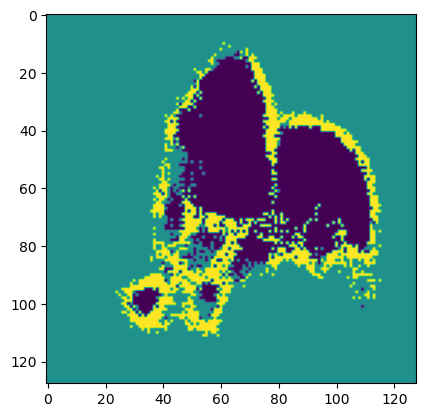

In [22]:
# 1개 배치(16개 이미지)를 선택
img, mask = next(iter(test_ds))

# 모델 예측
pred = unet_model.predict(img)

# 첫번째 이미지 분할 결과를 출력
pred_img=np.argmax(pred[0], -1)
plt.imshow(pred_img)

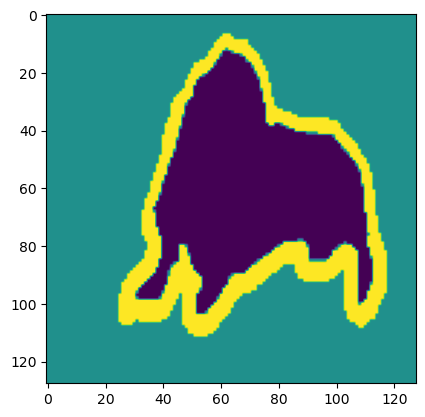

In [23]:
# 첫번째 이미지의 정답 마스크 출력
plt.imshow(np.reshape(mask[0], (128,128)))